# Supervised Shallow Machine Learning: Testing Classifiers

### Import Libraries including from `sklearn` for shallow ML

In [1]:
# For Data Wrangling:
import xarray as xr
import numpy as np

# ML Modeling:
from concurrent.futures import ThreadPoolExecutor, as_completed
import joblib

# For Data Plotting:
import matplotlib.pyplot as plt
import seaborn as sns

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

### Functions we will need to call later:

In [2]:
#------------------------------------------------------------------------------------------#
def get_band_mapping(MSI_data):
    """
    Create a mapping from our internal feature names to the expected band names 
    in the MSI dataset. If the dataset uses S2B naming (i.e. missing 'rhos_443'),
    rename the bands to match the S2A convention.
    
    Returns:
        mapping (dict): Maps feature keys (e.g., "560") to band names (e.g., "rhos_560").
        MSI_data (xarray.Dataset): Updated dataset with renamed bands if necessary.
    """
    mapping = {
        "560"  : "rhos_560",
        "665"  : "rhos_665",
        "704"  : "rhos_704",
        "740"  : "rhos_740",
        "783"  : "rhos_783",
        "833"  : "rhos_833",
        "865"  : "rhos_865",
        "1614" : "rhos_1614",
        "2202" : "rhos_2202"
    }
    try:
        _ = MSI_data["rhos_443"]
    except KeyError:
        # Update band names to match S2A convention if S2B naming is detected.
        MSI_data = MSI_data.rename({
            "rhos_442" : "rhos_443",
            "rhos_559" : "rhos_560",
            "rhos_739" : "rhos_740",
            "rhos_780" : "rhos_783",
            "rhos_864" : "rhos_865",
            "rhos_1610": "rhos_1614",
            "rhos_2186": "rhos_2202"
        })
    return mapping, MSI_data
    
#------------------------------------------------------------------------------------------#
def compute_zeroed_features(MSI_data):
    """
    Apply a zeroing operation to the MSI bands by subtracting the reference band 
    (2202) and clipping negative values. Then compute additional indices such as 
    NDVI, FDI, and SLOPE.
    
    Returns:
        features (dict): Contains the zeroed bands and computed indices.
    """
    mapping, MSI_data = get_band_mapping(MSI_data)
    
    # Extract the band values using the mapping.
    band560  = MSI_data[mapping["560"]].values
    band665  = MSI_data[mapping["665"]].values
    band704  = MSI_data[mapping["704"]].values
    band740  = MSI_data[mapping["740"]].values
    band783  = MSI_data[mapping["783"]].values
    band833  = MSI_data[mapping["833"]].values
    band865  = MSI_data[mapping["865"]].values
    band1614 = MSI_data[mapping["1614"]].values
    band2202 = MSI_data[mapping["2202"]].values  # Reference band
    
    # Helper function to zero out negative values after subtracting the reference.
    def zero_and_clip(band, ref):
        result = band - ref
        result[result < 0] = 0
        return result
    
    # Apply zeroing to each band.
    band560  = zero_and_clip(band560, band2202)
    band665  = zero_and_clip(band665, band2202)
    band704  = zero_and_clip(band704, band2202)
    band740  = zero_and_clip(band740, band2202)
    band783  = zero_and_clip(band783, band2202)
    band833  = zero_and_clip(band833, band2202)
    band865  = zero_and_clip(band865, band2202)
    band1614 = zero_and_clip(band1614, band2202)
    
    # Compute NDVI using safe division to avoid division by zero.
    denom = band833 + band665
    NDVI  = np.divide(band833 - band665, denom, out=np.zeros_like(denom), where=denom != 0)
    
    # Compute FDI (Floating Debris Index) and duplicate it as FDI_0.
    FDI   = band833 - (band704 + (band1614 - band740) * 1.636)
    FDI_0 = FDI
    
    # Compute SLOPE index.
    SLOPE = (band833 - band704) * 179

    return {
        "560"  : band560,
        "665"  : band665,
        "704"  : band704,
        "740"  : band740,
        "783"  : band783,
        "833"  : band833,
        "865"  : band865,
        "1614" : band1614,
        "NDVI" : NDVI,
        "SLOPE": SLOPE,
        "FDI_0": FDI_0,
        "FDI"  : FDI}

#------------------------------------------------------------------------------------------#
# Updated get_class to accept a model parameter
def get_class(MSI_data, model):
    """
    Build the feature matrix from MSI_data using preprocessed (zeroed) features,
    predict classes using the provided classifier model, and reshape the output
    to match the spatial dimensions.
    """
    features = compute_zeroed_features(MSI_data)
    feature_order = ["704", "740", "783", "833", "NDVI", "SLOPE", "FDI", "FDI_0"]
    sample_shape = features[feature_order[0]].shape
    
    # Flatten each feature to form the 2D feature matrix (one row per pixel)
    feature_matrix = np.column_stack([features[f].flatten() for f in feature_order])
    
    # Predict classes using the supplied model
    predictions = model.predict(feature_matrix)
    predictions = predictions.reshape(sample_shape)
    return predictions
    
#------------------------------------------------------------------------------------------#
def process_file(file):
    """
    Process a single MSI file: load data with chunking, run classification, 
    and extract geospatial extents for plotting.
    
    Returns:
        out_class_num (np.ndarray): Numeric classification result.
        label_uni (np.ndarray): Unique class labels found.
        extent (list): Geographic extent boundaries [lon_min, lon_max, lat_min, lat_max].
    """
    # Open the dataset with Dask chunking to avoid memory overload.
    MSI_data = xr.open_dataset(file, chunks={'lat': 512, 'lon': 512})
    
    # Get predicted classes (string labels) using our pre-processing functions.
    out_class = get_class(MSI_data)
    
    # Convert string labels to numeric codes for plotting.
    label_uni = np.unique(out_class)
    label_int = {label: i for i, label in enumerate(label_uni)}
    out_class_num = np.vectorize(label_int.get)(out_class)
    
    # Extract latitude and longitude arrays and determine plot extents.
    lat2d = MSI_data["lat"].values
    lon2d = MSI_data["lon"].values
    lon_min, lon_max = np.nanmin(lon2d), np.nanmax(lon2d)
    lat_min, lat_max = np.nanmin(lat2d), np.nanmax(lat2d)
    extent = [lon_min, lon_max, lat_min, lat_max]
    
    return out_class_num, label_uni, extent
    
#------------------------------------------------------------------------------------------#

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Testing Model on New Data
</div>

### Load new dataset and trained models

In [3]:
# Load subset sentinel-2 data
MSI_data = xr.open_dataset("subset__S2B_MSI_20180426_PUR_L2R_Barbados.nc") 

# Load yr trained classification models
model1 = joblib.load("RF_Classifier.pkl")
model2 = joblib.load("NB_Classifier.pkl")

In [4]:
# Run classification using trained models:
out_class_rf = get_class(MSI_data, model1)
out_class_nb = get_class(MSI_data, model2)

In [5]:
# Convert string labels to numeric codes for plotting (RF classes)
label_uni_rf = np.unique(out_class_rf)
label_int_rf = { label : i for i, label in enumerate(label_uni_rf) }
out_class_num_rf = np.vectorize(label_int_rf.get)(out_class_rf)

# Convert string labels to numeric codes for plotting (NB classes)
label_uni_nb = np.unique(out_class_nb)
label_int_nb = { label : i for i, label in enumerate(label_uni_nb) }
out_class_num_nb = np.vectorize(label_int_nb.get)(out_class_nb)

# Extract latitude and longitude arrays from MSI_data
lat2d = MSI_data["lat"].values
lon2d = MSI_data["lon"].values
lon_min, lon_max = np.nanmin(lon2d), np.nanmax(lon2d)
lat_min, lat_max = np.nanmin(lat2d), np.nanmax(lat2d)
extent = [lon_min, lon_max, lat_min, lat_max]

### Plotting predicated classes

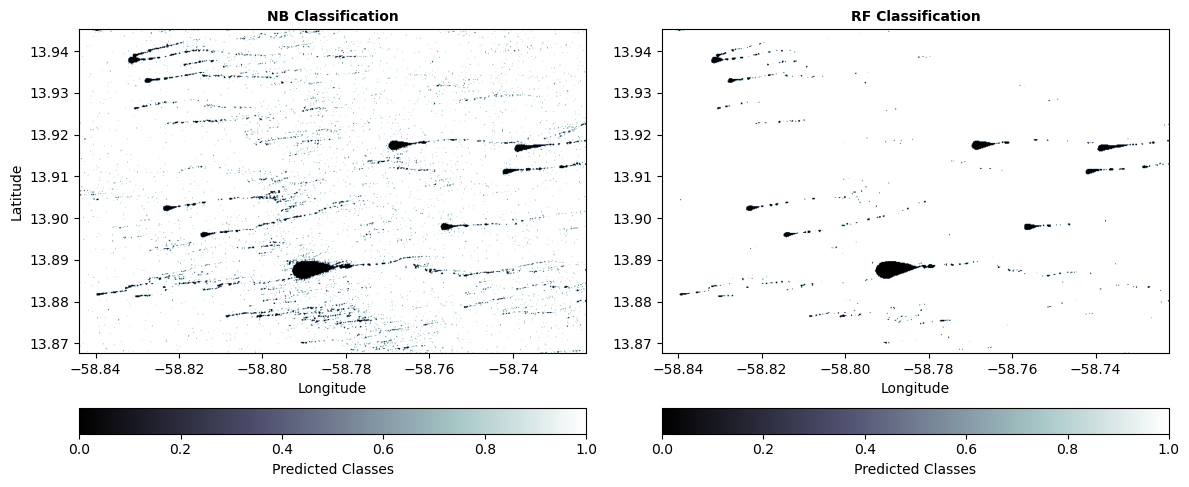

In [6]:
# Plot the classification results side by side
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# Plot Gaussian Naive Bayes classification result
im1 = axs[0].imshow(out_class_num_nb, cmap = "bone", origin = "upper", extent = extent)
axs[0].set_title("NB Classification", fontsize = 10, weight = "bold")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
cbar1 = plt.colorbar(im1, ax = axs[0], orientation = "horizontal", fraction = 0.1, pad = 0.1)
cbar1.set_label("Predicted Classes", fontsize = 10)

# Plot Random Forest classification result
im2 = axs[1].imshow(out_class_num_rf, cmap = "bone", origin = "upper", extent = extent)
axs[1].set_title("RF Classification", fontsize = 10, weight = "bold")
axs[1].set_xlabel("Longitude")
cbar2 = plt.colorbar(im2, ax = axs[1], orientation = "horizontal", fraction = 0.1, pad = 0.1)
cbar2.set_label("Predicted Classes", fontsize = 10)

plt.tight_layout()
plt.show()